[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

In [1]:
pip install tsfresh

In [2]:
pip install tslearn

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "17"

In [4]:
from tsfresh.examples import load_robot_execution_failures
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures

download_robot_execution_failures()
df_ts, y = load_robot_execution_failures()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

extracted_features = impute(extract_features(df_ts, column_id="id", column_sort="time"))
features_filtered = select_features(extracted_features, y)

Feature Extraction: 100%|██████████| 5/5 [00:39<00:00,  7.99s/it]
/usr/local/lib/python3.7/dist-packages/tsfresh/utilities/dataframe_functions.py:172: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__matrix_profile__feature_"median"__threshold_0.98'
 'T_z__matrix_profile__feature_"25"__threshold_0.98'
 'T_z__matrix_profile__feature_"75"__threshold_0.98'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


In [7]:
from tsfresh.transformers import RelevantFeatureAugmenter
import pandas as pd

X = pd.DataFrame(index=y.index)
TRAINING_SIZE = (len(X) // 10) * 8
augmenter = RelevantFeatureAugmenter(column_id='id', column_sort='time')
augmenter.set_timeseries_container(df_ts[:TRAINING_SIZE])
augmenter.fit(X[:TRAINING_SIZE], y[:TRAINING_SIZE])
X_transformed = augmenter.transform(X)

Feature Extraction: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]
/usr/local/lib/python3.7/dist-packages/tsfresh/utilities/dataframe_functions.py:172: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__matrix_profile__feature_"median"__threshold_0.98'
 'T_z__matrix_profile__feature_"25"__threshold_0.98'
 'T_z__matrix_profile__feature_"75"__threshold_0.98'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


RelevantFeatureAugmenter(chunksize=None, column_id='id', column_kind=None,
                         column_sort='time', column_value=None,
                         default_fc_parameters=None, disable_progressbar=False,
                         fdr_level=0.05, filter_only_tsfresh_features=True,
                         hypotheses_independent=False,
                         kind_to_fc_parameters=None, ml_task='auto',
                         multiclass=False, multiclass_p_values='min', n_jobs=1,
                         n_significant=1,...
                         test_for_binary_target_real_feature='mann',
                         test_for_real_target_binary_feature='mann',
                         test_for_real_target_real_feature='kendall',
                         timeseries_container=    id  time  F_x  F_y  F_z  T_x  T_y  T_z
0    1     0   -1   -1   63   -3   -1    0
1    1     1    0    0   62   -3   -1    0
2    1     2   -1   -1   61   -3    0    0
3    1     3   -1   -1   63   

In [9]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier()
param_search = {
    'metric' : ['dtw'],  # ctw', 'dtw', "softdtw"], # TSLEARN_VALID_METRICS}
    'n_neighbors': [1, 2, 3]
}
#  'param_grid': {'metric': ['ctw', 'dtw', 'gak', 'sax', 'softdtw', 'lcss']},
tscv = TimeSeriesSplit(n_splits=2)

gsearch = GridSearchCV(
    estimator=knn,
    cv=tscv,
    param_grid=param_search
)
gsearch.fit(
    features_filtered,
    y
)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             error_score=nan,
             estimator=KNeighborsTimeSeriesClassifier(metric='dtw',
                                                      metric_params=None,
                                                      n_jobs=None,
                                                      n_neighbors=5, verbose=0,
                                                      weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['dtw'], 'n_neighbors': [1, 2, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [10]:
# Adapted from comments on this discussion thread on stackoverflow: https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
import seaborn as sns
import pandas as pd

def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return fig


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


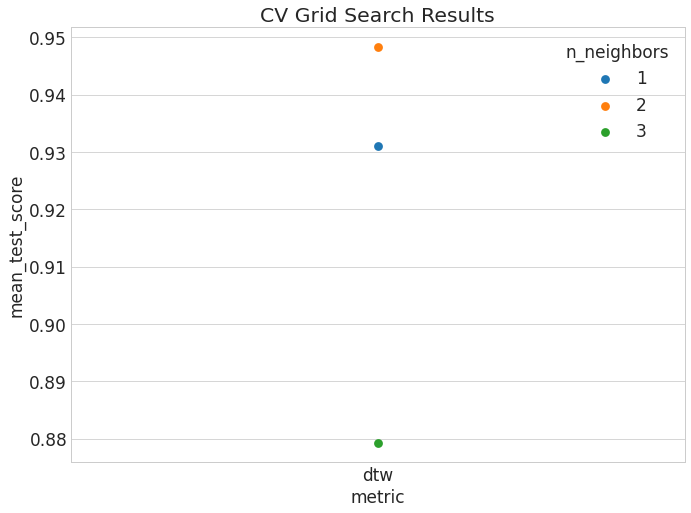

In [11]:
fig = plot_cv_results(gsearch.cv_results_, 'metric', 'n_neighbors')